# Processing Indoor Files, Modified from Laura Yang

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import smps
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot
from smps.fit import LogNormal
import plotly as py
import pyarrow.feather as feather
sns.set("notebook", "ticks", palette='colorblind') 
%matplotlib inline

In [2]:
folder = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/Raw/'
input_raw = folder + 'QuantAQ_Klaus_raw&final_Short_forIgor.csv'

In [3]:
#Load the raw file 
df = dd.read_csv(input_raw, parse_dates = ['timestamp','timestamp_local']).compute()

In [4]:
#Drop the duplicated measurements
df = df.drop_duplicates(subset=['timestamp'])

In [5]:
# del unneccesary columns
del df['lat']
del df['lon']
del df['sample_pres'], df['device_state'], df['id']

In [6]:
# Set the index to be the timestamp_local
df.set_index("timestamp_local", inplace=True) 

# Only keep un-flagged data
df = df.query("flag == 0")

#Sort the timestamp_local so that it starts from lowest to highest date
df = df.sort_index()

#Specify start and end date of interest
t0= "2022-04-06 19:32" #impactor removed 4/6/2022 at 7:32 pm
tf = "2022-04-12 19:00"

# #Specify start and end date of interest
# t0= "2022-04-08 00:00" #shortened time of interest, starting after 4/7 peak
# tf = "2022-04-12 19:00"

# #Specify start and end date of interest
# t0= "2022-04-06 19:32" #excluding 4/7 peak
# tf = "2022-04-12 19:00"

# Keep only data between start and stop 
df = df[t0:tf]
# df = df.drop(index = df.loc["2022-04-07 18:00":"2022-04-08 00:00", :].index)

In [7]:
# export the data both to csv
df.to_csv(folder + 'MODPM-raw-final-merged.csv')
# df.to_csv(folder + 'MODPM-raw-final-merged_Shortened.csv')
# df.to_csv(folder + 'MODPM-raw-final-merged_Excluded.csv')

In [8]:
# only keep rows where the values are positive
df = df[df['bin0'] >= 0.]
df = df[df['bin1'] >= 0.]
df = df[df['bin2'] >= 0.]
df = df[df['bin3'] >= 0.]
df = df[df['bin4'] >= 0.]
df = df[df['bin5'] >= 0.]
df = df[df['bin6'] >= 0.]
df = df[df['bin7'] >= 0.]
df = df[df['bin8'] >= 0.]
df = df[df['bin9'] >= 0.]
df = df[df['bin10'] >= 0.]
df = df[df['bin11'] >= 0.]
df = df[df['bin12'] >= 0.]
df = df[df['bin13'] >= 0.]
df = df[df['bin14'] >= 0.]
df = df[df['bin15'] >= 0.]
df = df[df['bin16'] >= 0.]
df = df[df['bin17'] >= 0.]
df = df[df['bin18'] >= 0.]
df = df[df['bin19'] >= 0.]
df = df[df['bin20'] >= 0.]
df = df[df['bin21'] >= 0.]
df = df[df['bin22'] >= 0.]
df = df[df['bin23'] >= 0.]
df = df[df['pm1'] >= 0.]
df = df[df['pm25'] >= 0.]
df = df[df['pm10'] >= 0.]

# identify the columns to keep
cols_to_keep = ['sample_temp', 'sample_rh','pm1', 'pm25', 'pm10','bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5',
                'bin6','bin7','bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13',
                'bin14','bin15','bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21',
                'bin22','bin23' ,'neph_bin0', 'neph_bin1', 'neph_bin2', 'neph_bin3', 
                'neph_bin4', 'neph_bin5', 'pm1_env', 'pm25_env', 'pm10_env']

# keep only certain columns
df = df[cols_to_keep]
df.index = df.index.tz_localize(None)

In [9]:
# Resample to a 5min time-base
df_1min = df.resample("1min").mean()
df_1min.reset_index()
df_1min.to_csv(folder + 'MODPM-final-1min.csv')
# df_1min.to_csv(folder + 'MODPM-final-1min_Shortened.csv')
# df_1min.to_csv(folder + 'MODPM-final-1min_Excluded.csv')

df_6min = df.resample("6min").mean()
df_6min.reset_index()
df_6min.to_csv(folder + 'MODPM-final-6min.csv')
# df_6min.to_csv(folder + 'MODPM-final-6min_Shortened.csv')
# df_6min.to_csv(folder + 'MODPM-final-6min_Excluded.csv')

In [10]:
input_raw = folder + 'class_mask_6min.csv'
classes = dd.read_csv(input_raw, parse_dates = ['timestamp_local']).compute()

input_raw = folder + 'observed_class_mask_6min.csv'
o_classes = dd.read_csv(input_raw, parse_dates = ['timestamp_local']).compute()

df_6min.loc[:, 'class_mask'] = list(classes['class_time'])
df_6min.loc[:, 'observed_class_mask'] = list(o_classes['class time'])

### Load SMPS data
Create SMPS object

In [11]:
df2 = pd.read_csv(
    folder + 'SMPS_Number_Klaus_Indoor.csv',
    skiprows = 25
)

def isfloat(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

#Determine the total number of channels
n_channels = sum([isfloat(x) for x in df2.columns])

#Next determine the index of the first channel
channel0_idx = [i for i, x in enumerate([isfloat(x) for x in df2.columns]) if x][0]

#Convert to a datetime object
df2['timestamp']=df2['Date'].map(pd.to_datetime)

#Grab the bin diameters
midpoints = df2.columns[channel0_idx:channel0_idx+n_channels]
binlabels = ['bin{}'.format(i) for i in range(n_channels)]

#Rename the columns to bin<X>
df2.rename(columns=dict(zip(midpoints,binlabels)),inplace=True)

#Set the index for the data dataframe
df2.set_index('timestamp',inplace=True)

# # df2.index = df2.index.tz_localize('US/Eastern') --> Spring so no need
# df2.index = df2.index - pd.Timedelta(hours=1)

df2 = df2[t0:tf].copy()
# df2 = df2.drop(index = df2.loc["2022-04-07 18:00":"2022-04-08 00:00", :].index)

# Resample to a 5 min timebase
df2 = df2.resample('6min').mean()

# Build out a nx3 array of the bin boundaries
bins = smps.utils.make_bins(
    midpoints=midpoints,
    lb = df2['Lower Size (nm)'][0],
    ub = df2['Upper Size (nm)'][0],
    channels_per_decade=64,
)

#B uild a generic Particle Sizer Object 
obj = smps.GenericParticleSizer(
    data=df2.copy(),
    bins=bins,
    fmt='dn',
    dp_units='nm',
    bin_labels=binlabels
)

In [12]:
midpoints

Index(['17.5', '18.1', '18.8', '19.5', '20.2', '20.9', '21.7', '22.5', '23.3',
       '24.1',
       ...
       '710.5', '736.5', '763.5', '791.5', '820.5', '850.5', '881.7', '914',
       '947.5', '982.2'],
      dtype='object', length=113)

In [13]:
# df2.to_csv(folder + 'SMPS_forIgor_Shortened.csv')
df2.to_csv(folder + 'SMPS_forIgor.csv')
# df2.to_csv(folder + 'SMPS_forIgor_Excluded.csv')

### Create tmp df

In [14]:
tmp = obj.data[["Median (nm)", "Mean (nm)", "Mode (nm)", "Geo. Mean (nm)"]].copy() 
# Add the SMPS PM1
tmp["PM1_SMPS"] = obj.integrate(dmin=0, dmax=1., weight='mass', rho=1.65)
tmp['PM1_SMPS'].mask(tmp['PM1_SMPS'] == 0, np.nan, inplace = True) #replacing values where PM1_SMPS=0 with np.nan
# Add the SMPS PM1
tmp["PM_350_SMPS"] = obj.integrate(dmin=0.35, dmax=1., weight='mass', rho=1.65)
tmp["PM_300_SMPS"] = obj.integrate(dmin=0.30, dmax=1., weight='mass', rho=1.65)
# Fraction above 350 nm
tmp["% > 350nm"] = tmp["PM_350_SMPS"] / tmp["PM1_SMPS"] 
# Fraction above 350 nm
tmp["% > 300nm"] = tmp["PM_300_SMPS"] / tmp["PM1_SMPS"] 
# Add the MODULAIR data
tmp["PM1_modpm"] = df_6min['pm1']
tmp["PM25_modpm"] = df_6min['pm25']
tmp["PM10_modpm"] = df_6min['pm10']
tmp["PM1-25_modpm"] = df_6min['pm25']-df_6min['pm1']
tmp["PM25-10_modpm"] = df_6min['pm10']-df_6min['pm25']
tmp["PM1_frac_modpm"] = df_6min['pm1']/(df_6min['pm1']+df_6min['pm25']+df_6min['pm10'])
tmp["PM25_frac_modpm"] = df_6min['pm25']/(df_6min['pm1']+df_6min['pm25']+df_6min['pm10'])
tmp["PM10_frac_modpm"] = df_6min['pm10']/(df_6min['pm1']+df_6min['pm25']+df_6min['pm10'])
# Add the Nephelometer data
tmp["PM1_neph"] = df_6min['pm1_env']
tmp["PM25_neph"] = df_6min['pm25_env']
tmp["PM10_neph"] = df_6min['pm10_env']
tmp["PM1-25_neph"] = df_6min['pm25_env']-df_6min['pm1_env']
tmp["PM25-10_neph"] = df_6min['pm10_env']-df_6min['pm25_env']
tmp["PM1_frac_neph"] = df_6min['pm1_env']/(df_6min['pm1_env']+df_6min['pm25_env']+df_6min['pm10_env'])
tmp["PM25_frac_neph"] = df_6min['pm25_env']/(df_6min['pm1_env']+df_6min['pm25_env']+df_6min['pm10_env'])
tmp["PM10_frac_neph"] = df_6min['pm10_env']/(df_6min['pm1_env']+df_6min['pm25_env']+df_6min['pm10_env'])
#Ratios PM2.5/PM1
tmp["PM25/PM1_neph"] = df_6min['pm25_env']/df_6min['pm1_env']
tmp["PM25/PM1_modpm"] = df_6min['pm25']/df_6min['pm1']

tmp['PMS PM1 bias'] = (tmp["PM1_neph"]-tmp["PM1_SMPS"])/tmp["PM1_SMPS"]
tmp['modpm PM1 bias'] = (tmp["PM1_modpm"]-tmp["PM1_SMPS"])/tmp["PM1_SMPS"]
tmp['temp'] = df_6min['sample_temp']
tmp['rh'] = df_6min['sample_rh']
# tmp['pres'] = df_6min['sample_pres']

tmp['class_time'] = df_6min['class_mask']
tmp['obseved_class'] = df_6min['observed_class_mask']

In [15]:
tmp.to_csv(folder + 'timeseries_forIgor.csv')
# tmp.to_csv(folder + 'timeseries_forIgor_Shortened.csv')
# tmp.to_csv(folder + 'timeseries_forIgor_Excluded.csv')

### No fogging

In [16]:
# No fogging
folder = input_raw = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/Raw/'
df = pd.read_csv(folder + 'fogging_mask.csv', sep = ",", header = None)

#Specify start and end date of interest
t0= "2022-04-08 00:00" #shortened time of interest, starting after 4/7 peak
tf = "2022-04-12 19:00"

tmp = tmp[t0:tf].copy()

df = df.iloc[284:, :]
df.set_index(0)
# df = df.drop(index = df.loc["2022-04-07 18:00":"2022-04-08 00:00", :].index)

tmp['fogging_mask'] = df[1].values
tmp.mask(tmp['fogging_mask']==1, inplace= True)
tmp.dropna(axis=0, how = 'all', inplace=True)

# tmp.to_csv(folder + 'timeseries_forIgor_Nofogging.csv')
tmp.to_csv(folder + 'timeseries_forIgor_Nofogging_Shortened.csv')
# tmp.to_csv(folder + 'timeseries_forIgor_Nofogging_Excluded.csv')

In [125]:
tmp

,Median (nm),Mean (nm),Mode (nm),Geo. Mean (nm),PM1_SMPS,PM_350_SMPS,PM_300_SMPS,% > 350nm,% > 300nm,PM1_modpm,...,PM10_frac_neph,PM25/PM1_neph,PM25/PM1_modpm,PMS PM1 bias,modpm PM1 bias,temp,rh,class_time,obseved_class,fogging_mask
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-08 00:00:00,49.313,68.491,47.829,55.672,1.256482,0.556169,0.603550,0.442640,0.480349,0.604283,...,0.500000,inf,1.161624,-1.000000,-0.519067,23.888333,29.341667,0.0,0.0,0.0
2022-04-08 00:06:00,49.614,69.711,41.418,56.214,1.309211,0.559262,0.629811,0.427175,0.481062,0.586383,...,NaN,NaN,1.185885,-1.000000,-0.552109,23.896667,29.340000,0.0,0.0,0.0
2022-04-08 00:12:00,48.548,67.842,44.508,55.173,1.289442,0.589327,0.649789,0.457040,0.503931,0.653717,...,NaN,NaN,1.149606,-1.000000,-0.493024,23.905000,29.316667,0.0,0.0,0.0
2022-04-08 00:18:00,48.714,67.580,39.954,55.239,1.146094,0.427651,0.485799,0.373138,0.423873,0.589450,...,0.941384,inf,1.182006,-1.000000,-0.485688,23.911667,29.318333,0.0,0.0,0.0
2022-04-08 00:24:00,48.517,68.700,44.508,55.649,1.405765,0.670301,0.735449,0.476823,0.523167,0.595883,...,0.500000,inf,1.125696,-1.000000,-0.576114,23.918333,29.323333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12 06:30:00,91.212,102.960,109.411,87.283,5.649964,1.333240,1.683611,0.235973,0.297986,5.050600,...,0.378344,1.362874,1.016381,-0.444451,-0.106083,23.631667,37.446667,0.0,0.0,0.0
2022-04-12 06:36:00,92.069,103.713,113.419,88.095,5.730358,1.477426,1.886989,0.257824,0.329297,4.440700,...,0.389448,1.438566,1.023544,-0.585512,-0.225057,23.630000,37.501667,0.0,0.0,0.0
2022-04-12 06:42:00,91.502,104.038,105.545,87.560,6.214189,1.893752,2.329863,0.304746,0.374926,4.303617,...,0.381745,1.401242,1.015146,-0.615584,-0.307453,23.635000,37.548333,0.0,0.0,0.0


In [338]:
# SMPS No fogging
# folder = input_raw = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/'
# df = pd.read_csv(folder + 'fogging_mask.csv', header = None)

df2['fogging_mask'] = df[1].values
df2.mask(df2['fogging_mask']==1, inplace= True)
df2.dropna(axis=0, how = 'all', inplace=True)

df2.to_csv(folder + 'SMPS_forIgor_NoFogging_Shortened.csv')
# df2.to_csv(folder + 'SMPS_forIgor_NoFogging.csv')
# df2.to_csv(folder + 'SMPS_forIgor_NoFogging_Excluded.csv')

In [219]:
# # All columns (basically bin data) No fogging
# # folder = input_raw = '/Users/zahrashivji/Dropbox/Shivji/Final Data/Indoor Files/Short/'
# # df = pd.read_csv(folder + 'fogging_mask.csv', header = None)

# df_6min['PM1_SMPS'] = obj.integrate(dmin=0, dmax=1., weight='mass', rho=1.65)
# df_6min['PM1_SMPS'].mask(df_6min['PM1_SMPS'] == 0, np.nan, inplace = True)

# df_6min['fogging_mask'] = df[1].values
# df_6min.mask(df_6min['fogging_mask']==1, inplace= True)
# df_6min.dropna(axis=0, how = 'all', inplace=True)

# # df_6min.to_csv(folder + 'MODPM-final-6min_Nofogging_Shortened.csv')
# df_6min.to_csv(folder + 'MODPM-final-6min_Nofogging.csv')

In [46]:
import statsmodels.formula.api as smf

dat = tmp

results = smf.ols("PM1_neph ~ PM1_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     5590.
Date:                Sun, 30 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:50:24   Log-Likelihood:                 175.79
No. Observations:                 982   AIC:                            -347.6
Df Residuals:                     980   BIC:                            -337.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3426      0.010    -33.790      0.0

In [312]:
import statsmodels.formula.api as smf

dat = tmp

results = smf.ols("PM1_modpm ~ PM1_SMPS",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM1_modpm   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1406.
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          2.62e-206
Time:                        22:12:03   Log-Likelihood:                -1177.3
No. Observations:                1241   AIC:                             2359.
Df Residuals:                    1239   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2981      0.028     10.625      0.0

In [316]:
import statsmodels.formula.api as smf

dat = tmp

results = smf.ols("PM25_neph ~ PM25_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              PM25_neph   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:14:05   Log-Likelihood:                 58.324
No. Observations:                1250   AIC:                            -112.6
Df Residuals:                    1248   BIC:                            -102.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5426      0.011    -48.149      0.0

<AxesSubplot:xlabel='timestamp'>

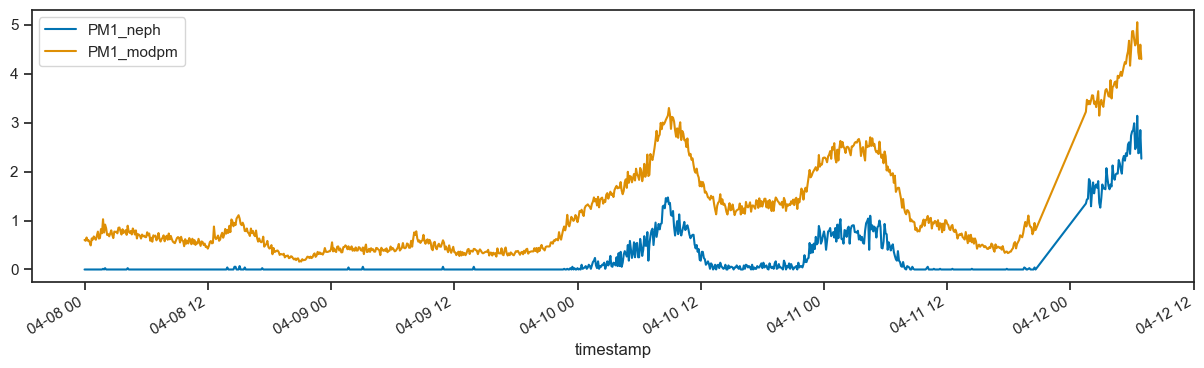

In [45]:
tmp4 = tmp.loc['2022-04-06':'2022-04-12',['PM1_modpm','PM1_neph']]
tmp4[['PM1_neph','PM1_modpm']].plot(figsize=(15,4))

In [47]:
fig = px.scatter(
    tmp,
    x= "PM1_modpm", y="PM1_neph", trendline = 'ols')

fig.update_layout(
    autosize=True,
    xaxis=dict(title_text="$\\text{REFERENCE }PM_1 [μg/m^{3}]$"),
    yaxis=dict(title_text="$\\text{LCS }PM_1 [μg/m^{3}]$")
) 

fig.show()

In [17]:
#only keeping daa where PM1_modpm < 2 ug/m3 to matcj WV data
tmptmp = tmp.where(tmp['PM1_modpm'] < 2, other = np.nan)
tmptmp = tmptmp.dropna()

fig = px.scatter(
    tmptmp,
    x="PM1_modpm", y="PM1_neph", trendline = 'ols')

fig.update_layout(
    autosize=True,
    xaxis=dict(title_text="$\\text{MODULAIR-PM }PM_1 [μg/m^{3}]$"),
    yaxis=dict(title_text="$\\text{PMS }PM_1 [μg/m^{3}]$")
) 

fig.show()

In [21]:
import statsmodels.formula.api as smf

dat = tmptmp

results = smf.ols("PM1_neph ~ PM1_modpm",data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               PM1_neph   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     683.9
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           2.85e-95
Time:                        18:02:28   Log-Likelihood:                 503.31
No. Observations:                 496   AIC:                            -1003.
Df Residuals:                     494   BIC:                            -994.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2090      0.012    -17.262      0.0

<AxesSubplot:xlabel='timestamp'>

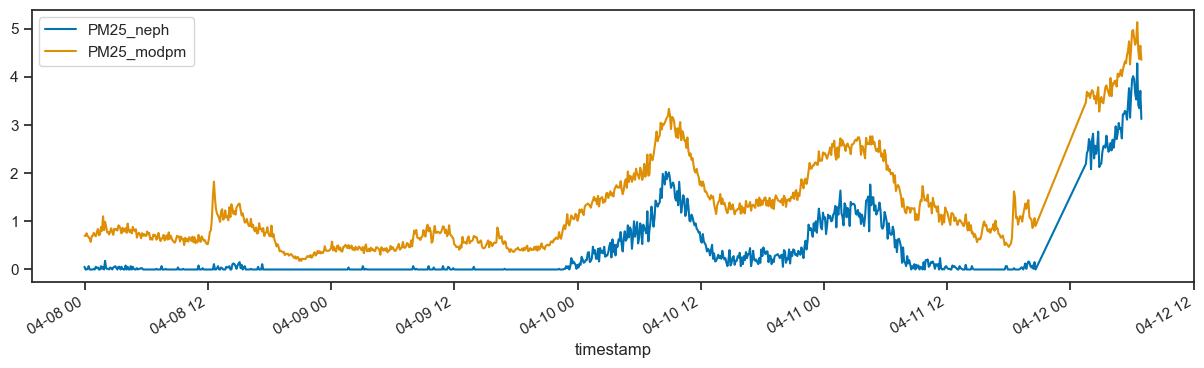

In [44]:
tmp4 = tmp.loc[:,['PM25_modpm','PM25_neph']]
tmp4[['PM25_neph', 'PM25_modpm']].plot(figsize=(15,4))

In [41]:
fig = px.scatter(
    tmp,
    x= "PM25_modpm", y="PM25_neph", trendline = 'ols')

fig.update_layout(
    autosize=True,
    xaxis=dict(title_text="$\\text{REFERENCE }PM_25 [μg/m^{3}]$"),
    yaxis=dict(title_text="$\\text{LCS }PM_25 [μg/m^{3}]$")
) 

fig.show()

<AxesSubplot:xlabel='timestamp'>

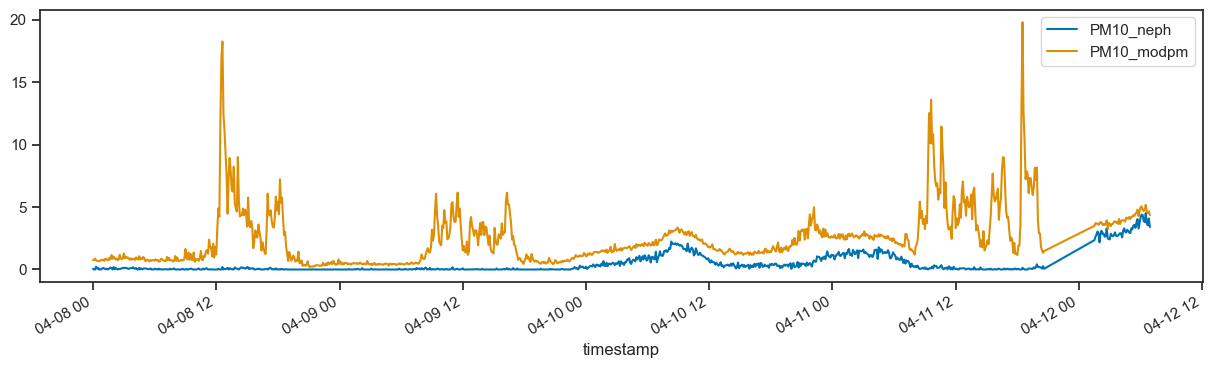

In [43]:
tmp4 = tmp.loc[:,['PM10_modpm','PM10_neph']]
tmp4[['PM10_neph','PM10_modpm']].plot(figsize=(15,4))

In [42]:
fig = px.scatter(
    tmp,
    x= "PM10_modpm", y="PM10_neph", trendline = 'ols')

fig.update_layout(
    autosize=True,
    xaxis=dict(title_text="$\\text{REFERENCE }PM_10 [μg/m^{3}]$"),
    yaxis=dict(title_text="$\\text{LCS }PM_10 [μg/m^{3}]$")
) 

fig.show()